## Essencial Functions and Libraries

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import numpy as np
import tifffile as tiff
from difflib import get_close_matches

## Read data

In [6]:
# Main dataset directory
dataset_dir = Path('spotlite_dataset_loca1_date1_dir1')

images_dir = dataset_dir / 'images'
masks_dir = dataset_dir / 'masks'

assert images_dir.exists(), f"Image folder not found: {images_dir}"
assert masks_dir.exists(), f"Mask folder not found: {masks_dir}"

# Collect all image and mask files (multiple extensions)
image_paths = sorted(
    [*images_dir.glob('*.tif'), *images_dir.glob('*.tiff')],
    key=lambda p: p.stem
)
mask_paths = sorted(
    [*masks_dir.glob('*.tif'), *masks_dir.glob('*.tiff'),
     *masks_dir.glob('*.png'), *masks_dir.glob('*.jpg')],
    key=lambda p: p.stem
)

# Dictionary of masks by base name
mask_dict = {p.stem: p for p in mask_paths}
unused_masks = set(mask_dict.keys())

imgs_array, masks_array = [], []

for img_path in image_paths:
    stem = img_path.stem
    mask_path = None

    # 1) Exact match
    if stem in mask_dict:
        mask_path = mask_dict[stem]
        unused_masks.discard(stem)
    else:
        # 2) Approximate match
        candidates = get_close_matches(stem, mask_dict.keys(), n=1, cutoff=0.6)
        if candidates:
            sel = candidates[0]
            mask_path = mask_dict[sel]
            unused_masks.discard(sel)
        else:
            # 3) No match found; just notify and skip
            print(f"Warning: no mask found for {img_path.name}; skipping.")
            continue

    # Read image and mask
    img = tiff.imread(str(img_path))
    msk = tiff.imread(str(mask_path))

    # Check dimensions
    if img.shape[:2] != msk.shape:
        raise ValueError(
            f"Incompatible dimensions: {img_path.name} {img.shape[:2]} vs "
            f"{mask_path.name} {msk.shape}"
        )

    imgs_array.append(img)
    masks_array.append(msk)

# Remaining masks
if unused_masks:
    print("Warning: these masks were not used (no corresponding image):")
    for s in sorted(unused_masks):
        print("  ", s)

# Stack arrays
imgs = np.stack(imgs_array, axis=0)   # (N, H, W, C)
masks = np.stack(masks_array, axis=0)  # (N, H, W)

print(f'Final: {len(imgs)} pairs loaded.')
print(f'Shape of imgs: {imgs.shape}')
print(f'Shape of masks: {masks.shape}')


Final: 391 pairs loaded.
Shape of imgs: (391, 512, 512, 4)
Shape of masks: (391, 512, 512)


## Convert labels in masks

In [5]:
# Convert labels in masks from 0, 3, 4 to 0, 1, 2
# where 0 is background, 1 is class 1, and 2 is class

# CLASSES_NAMES = ['background','no trees', 'other trees/vegetation','pinus','eucalyptus', 'shadow']
CLASSES_NAMES = ['background','pinus','eucalyptus']

def remap_mask(mask, remapping=False):
    if not torch.is_tensor(mask):
        mask = torch.from_numpy(mask)
      
    if remapping is False:
        return mask

    remapped = torch.zeros_like(mask)
    remapped[mask == 0] = 0
    remapped[mask == 1] = 0
    remapped[mask == 2] = 0
    remapped[mask == 3] = 1
    remapped[mask == 4] = 2
    remapped[mask == 5] = 0
    
    return remapped.long()

masks = remap_mask(masks, remapping=True)
np.unique_labels = np.unique(masks)
print(f'Unique labels in masks: {np.unique_labels}')

Unique labels in masks: [0 1 2]


## Extract features and labels

In [59]:
from skimage.color import rgb2hsv, rgb2lab

N, H, W, C = imgs.shape
X = imgs.reshape(-1, C)       # shape = (N*H*W, 4)
y = masks.reshape(-1)         # shape = (N*H*W,)

# NDVI = (NIR - R) / (NIR + R)
# [R, G, B] → check classic visual coupling

# [G, NIR, NDVI] → check if NDVI helps separate vegetation
# [NDVI, GNDVI, NIR] → check separation by indices
# [H, S, V] or [L, A, B] if converted to HSV or LAB

R = X[:, 0]
G = X[:, 1]
B = X[:, 2]
NIR = X[:, 3]

NDVI = (NIR - R) / (NIR + R + 1e-5)
GNDVI = (NIR - G) / (NIR + G + 1e-5)
NDWI = (G - NIR) / (G + NIR + 1e-5) 

# Stack RGB normalized to [0, 1]
rgb = np.stack([R, G, B], axis=1).astype(np.float32)
rgb_norm = (rgb - rgb.min(0)) / (rgb.max(0) - rgb.min(0) + 1e-5)  # normalization per channel

# Convert to HSV and LAB
hsv = rgb2hsv(rgb_norm.reshape(-1, 1, 3)).reshape(-1, 3) 
lab = rgb2lab(rgb_norm.reshape(-1, 1, 3)).reshape(-1, 3)

# Decompor HSV
Hue = hsv[:, 0]
Saturation = hsv[:, 1]
Value = hsv[:, 2]

# Decompor LAB
L = lab[:, 0]
A = lab[:, 1]
B_lab = lab[:, 2] 


In [60]:
# X = np.stack([
#     R, G, B,           
#     NIR,               
#     NDVI, GNDVI, NDWI,  
#     L, A, B_lab,       
#     Hue, Saturation, Value  
# ], axis=1)  

X = np.stack([
    R, G, B,           
    NIR,               
    NDVI, GNDVI, NDWI,
    L, A, B_lab,       
    Hue, Saturation, Value  
], axis=1)  

# amostragem para acelerar treino
idx = np.random.choice(len(y), size=10000000, replace=False)
X_sample, y_sample = X[idx], y[idx]

print(f'shape of X: {X_sample.shape}')
print(f'shape of y: {y_sample.shape}')

shape of X: (10000000, 13)
shape of y: torch.Size([10000000])


## Check Inbalance

Class 0 (background): 980,116 pixels (98.01%)
Class 1 (pinus): 6,784 pixels (0.68%)
Class 2 (eucalyptus): 13,100 pixels (1.31%)
   class  counts  percent
0      0  980116  98.0116
1      1    6784   0.6784
2      2   13100   1.3100


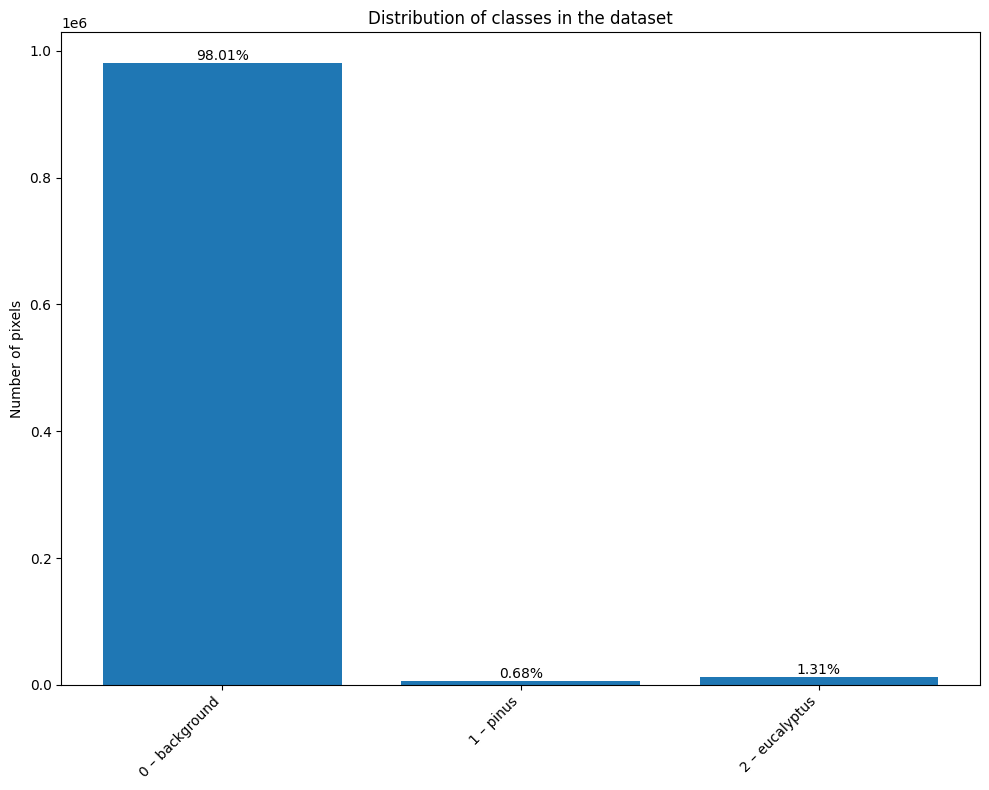

In [55]:
y = np.array(y_sample)

# Flatten the array to get the total count per class
y_flat = y.reshape(-1)
total_pixels = y_flat.size
classes, counts = np.unique(y_flat, return_counts=True)

# Detailed print
for cls, ct in zip(classes, counts):
    pct = ct / total_pixels * 100
    print(f"Class {cls} ({CLASSES_NAMES[cls]}): {ct:,} pixels ({pct:.2f}%)")

# Create a DataFrame with the distribution
df_dist = pd.DataFrame({
    "class":   classes,
    "counts":  counts,
    "percent": counts / total_pixels * 100
})

print(df_dist)

# Create labels for the X-axis
x_labels = [f"{cls} – {CLASSES_NAMES[cls]}" for cls in df_dist['class']]

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.bar(df_dist['class'], df_dist['counts'])

ax.set_ylabel('Number of pixels')
ax.set_title('Distribution of classes in the dataset')

ax.set_xticks(df_dist['class'])
ax.set_xticklabels(x_labels, rotation=45, ha='right')

# Add percentages above the bars
for bar, pct in zip(bars, df_dist['percent']):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    ax.text(x, y, f"{pct:.2f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Split training/testing

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.25, random_state=42, stratify=y_sample
)

print(f'shape of X_train: {X_train.shape}')
print(f'shape of y_train: {y_train.shape}')
print(f'shape of X_test: {X_test.shape}')
print(f'shape of y_test: {y_test.shape}')

shape of X_train: (7500000, 13)
shape of y_train: torch.Size([7500000])
shape of X_test: (2500000, 13)
shape of y_test: torch.Size([2500000])


### Train Random Forest 

=== Classification Report ===
              precision    recall  f1-score   support

  background     0.9979    0.8043    0.8907   2450701
       pinus     0.0347    0.7964    0.0666     16800
  eucalyptus     0.2164    0.9293    0.3510     32499

    accuracy                         0.8059   2500000
   macro avg     0.4163    0.8433    0.4361   2500000
weighted avg     0.9812    0.8059    0.8782   2500000



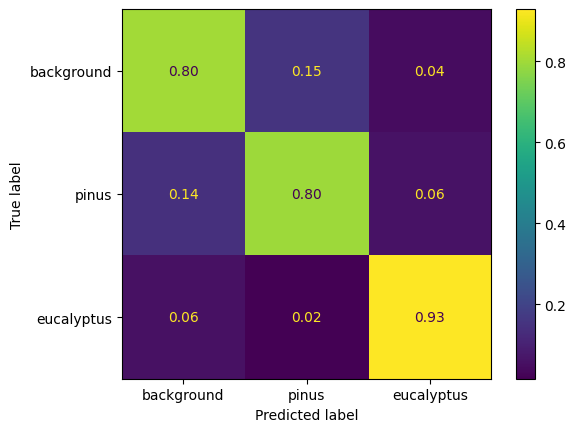

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# ja testei aqui com otimização de hiperparâmetros baysiana, mas deu o mesmo resultado com essa forma simples

# classe_names = ['background','no trees', 'other trees/vegetation','pinus','eucalyptus', 'shadow']


rf = RandomForestClassifier(
    n_estimators=20,
    max_depth=15,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("=== Classification Report ===")
print(classification_report(
  y_test, y_pred,
  target_names=CLASSES_NAMES, digits=4
))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    normalize='true',
    display_labels=CLASSES_NAMES,
    values_format='.2f'      
)
